In [10]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as fun
import numpy as np
import pandas as pd

# Load do dataset

In [11]:
from lib.data import load_dataset

rs = 2

x_train, y_train, x_valid, y_valid = load_dataset('dts/dts_all/train.csv',rs=rs)
x_test = load_dataset('dts/dts_all/test.csv',test_only=True,rs=rs)

# Normalização

In [12]:
from sklearn.preprocessing import StandardScaler
from my_nn import dts

sc = StandardScaler()
sc.fit(x_train.values)

x_train = sc.transform(x_train.values)
x_valid = sc.transform(x_valid.values)
x_test = sc.transform(x_test.values)

# Feature Selection

In [13]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

selec_mod = SelectFromModel(estimator=LogisticRegression(random_state=rs, max_iter=2000)).fit(x_train, y_train)

x_train = selec_mod.transform(x_train)
x_valid = selec_mod.transform(x_valid)
x_test = selec_mod.transform(x_test)

# Dataloaders

In [14]:
from torch.utils.data import DataLoader
train_dts = dts(x_train,y_train)
valid_dts = dts(x_valid,y_valid)

training_loader = DataLoader(train_dts, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dts, batch_size=32, shuffle=True)

In [15]:
from my_nn import nnModel

model = nnModel(inFeatures = x_train.shape[1], random_state=2)

losses, accs = model.fit(
    trainloader=training_loader,
    validloader=valid_loader,
    learningRate=0.02,
    momentum=0.9,
    gamma=0.97,
    numEpochs=31,
    verbose=False
)

[342.55393143743277, 160.10186089249328, 105.11545635806397, 75.51159698603442, 63.57035344024189, 43.84199487688602, 38.35808648209786, 30.39617118311071, 31.13258135337128, 21.320861849502762, 16.07161115899453, 15.569913870470373, 9.001668879010595, 16.105460310179296, 10.119769777516694, 6.873818316258891, 1.2907688099182195, 0.47433402735246233, 0.21476890553338812, 0.14126959507262926, 0.05600842029755704, 0.043649879877184716, 0.038117458215269906, 0.034237666649363785, 0.03112719800088115, 0.028778183225358855, 0.026818356872590154, 0.02510991163253795, 0.02372143487970213, 0.02245663067574366, 0.021343725743967035]
[94.5875, 97.0375, 97.775, 98.3625, 98.3, 98.2875]


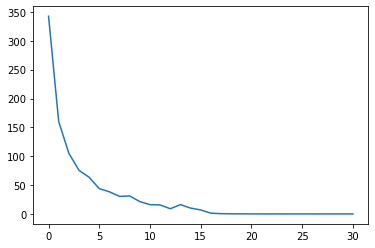

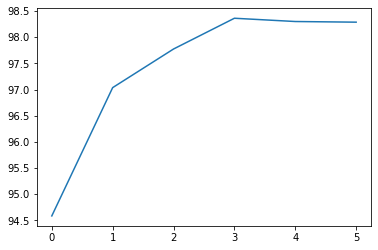

In [16]:
print(losses)
print(accs)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(losses)
plt.figure()
plt.plot(accs)

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

yvalid = model.predict(torch.tensor(x_valid, dtype=torch.float32))

print("Acc: {:.3f}".format(accuracy_score(y_true=y_valid, y_pred=yvalid)))
print("ROC: {:.3f}".format(roc_auc_score(y_valid, yvalid)))
print("Acc: {:.3f}".format(precision_score(y_true=y_valid, y_pred=yvalid)))
print("Acc: {:.3f}".format(recall_score(y_true=y_valid, y_pred=yvalid)))

Acc: 0.983
ROC: 0.983
Acc: 0.988
Acc: 0.978


In [18]:
ypred = model.predict(torch.tensor(x_test, dtype=torch.float32))
import pandas as pd
result = pd.DataFrame(data={
        "Id": range(len(ypred)),
        "Category": ypred.astype(int)
    }, index=None)

result.to_csv("result.csv", index=None)